In [2]:
#----------------------------------------------------------------------#
#                     EXAMPLE 0 (1D PROBLEM).                          #
#                                                                      #
#   Este programa resuleve la ecuacón de Poisson:                      #
#               u_xx + k^2*u =  0,  x en (0,pi).                         #
#   con condición de frontera tipo Dirichlet                           #
#                 u(-1) = 0 and u(1) = 0                               #
#   La solución exacta es:                                             #
#                      u(x,y) = sin(k*x)                              #
#----------------------------------------------------------------------#
#  Citar como:                                                         #
#----------------------------------------------------------------------#

# Importación de bibliotecas necesarias para el modelo y visualización

import tensorflow as tf            # Construir y entrenar modelos de machine learning
import numpy as np                 # Cálculos numéricos eficientes con arreglos y matrices
import matplotlib.pyplot as plt    # Gráficos y visualizar datos
import time


In [3]:
#----------------------------------------------------------------------#
# Definición de funciones: solución exacta y término fuente
#----------------------------------------------------------------------#
# Definimos la constante pi en tensorflow
pi = tf.constant(np.pi, dtype=tf.float32)

# Función que representa la solución exacta del problema
@tf.function
def u_exact(x):
    return tf.sin(pi * x)

# Función que define el término fuente de la EDP
@tf.function
def rhs(x):
    return (1.0 - pi**2) * tf.sin(pi * x)

In [4]:
#----------------------------------------------------------------------#
# Definición del modelo de red neuronal y su evaluación
#----------------------------------------------------------------------#

# Se construye un modelo secuencial de Keras con tres capas ocultas de
# 50 neuronas y activación tanh, seguido de una capa de salida con una
# sola neurona para producir una salida escalar.

# Modelo secuencial de Keras (3 capas ocultas y 1 capa de salida)
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(10, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return model

# Evaluación del modelo (paso hacia adelante)
def call_model(model, x):
    return model(x)



In [5]:
#----------------------------------------------------------------------#
# Definición de la ecuación diferencial mediante autogradiente
# y de la función de pérdida
#----------------------------------------------------------------------#

# Se usa tf.GradientTape para calcular derivadas automáticas.
# La función `pde` define la ecuación diferencial y la función `loss`
# calcula el error total combinando el residuo de la PDE en el dominio interior
# y el error en las condiciones de frontera.

# Define la ecuación diferencial usando derivadas automáticas
@tf.function(reduce_retracing=True)
def pde(x, model):
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            u = model(x, training=True)
        u_x = tape1.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)

    return u_xx + u - rhs(x)

# Define la función de pérdida total (dominio + frontera)
def loss(model, x, x_bc, y_bc):
    res = pde(x, model)                                # Evaluación de la PDE en puntos interiores
    y_bc_pred = call_model(model, x_bc)                # Predicción en puntos de frontera

    loss_pde  = tf.reduce_mean(tf.square(res))               # Error en el dominio
    loss_bc   = tf.reduce_mean(tf.square(y_bc - y_bc_pred))  # Error en las condiciones de frontera

    return loss_pde + loss_bc                          # Pérdida total (interior + frontera)



In [6]:
#----------------------------------------------------------------------#
# Definición del paso de entrenamiento
#----------------------------------------------------------------------#

# En este bloque se define cómo se actualizan los pesos del modelo en
# una iteración de entrenamiento. Se calcula el valor de la función de
# pérdida, se obtienen sus gradientes respecto a los parámetros entrenables
# del modelo y se actualizan usando un optimizador de TensorFlow.

# Ejecuta un paso de entrenamiento para el modelo
@tf.function
def train_step(model, x, x_bc, y_bc, optimizer):
    with tf.GradientTape() as tape:                   # Graba operaciones para calcular gradientes
        loss_value = loss(model, x, x_bc, y_bc)       # Evalúa la función de pérdida

    variables = model.trainable_variables             # Obtiene las variables (pesos y sesgos) entrenables del modelo
    grads     = tape.gradient(loss_value, variables)  # Calcula los gradientes de la pérdida respecto a las variables
    optimizer.apply_gradients(zip(grads, variables))  # Aplica los gradientes usando el optimizador
    return loss_value                                 # Devuelve el valor actual de la pérdida


In [7]:
#----------------------------------------------------------------------#
# Configuración y entrenamiento del problema
#----------------------------------------------------------------------#

# Se define el dominio del problema, se generan los datos de
# entrenamiento (interior y frontera), se construye el modelo,
# se configura el optimizador con una tasa de aprendizaje decreciente,
# y se entrena la red neuronal durante un número fijo de épocas.

xI = -1   # Límite izquierdo del dominio
xF = 1   # Límite derecho del dominio

Nf = 28

x_train = np.linspace(xI, xF, Nf, endpoint = False).reshape(-1, 1)          # 100 puntos uniformemente distribuidos en el dominio
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)  # Conversión a tensor de TensorFlow

uI = u_exact(xI)                         # Valor exacto de la solución en x = xI
uF = u_exact(xF)                         # Valor exacto de la solución en x = xF

x_bc = np.array([[xI], [xF]], dtype=np.float32)          # Puntos de frontera (xI y xF)
y_bc = np.array([[uI], [uF]], dtype=np.float32)          # Valores de la solución en la frontera

x_bc = tf.convert_to_tensor(x_bc, dtype=tf.float32)      # Conversión a tensor (x de frontera)
y_bc = tf.convert_to_tensor(y_bc, dtype=tf.float32)      # Conversión a tensor (u de frontera)

model = create_model()                   # Se crea el modelo de red neuronal

# Se define una política de decaimiento exponencial para la tasa de aprendizaje
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,          # Tasa de aprendizaje inicial
    decay_steps=1000,                    # Número de pasos antes de aplicar el decaimiento
    decay_rate=0.9                       # Factor de decaimiento
    )

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)  # Optimizador Adam con tasa de aprendizaje ajustable

epochs = 5000                            # Número total de épocas de entrenamiento

start_time = time.time()
for epoch in range(epochs):
    loss_value = train_step(model, x_train, x_bc, y_bc, optimizer)  # Ejecuta un paso de entrenamiento
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")        # Muestra pérdida cada 100 épocas
    if epoch == epochs-1:
        print(f"Epoch {epoch}: Final loss = {loss_value.numpy()}")  # Muestra la pérdida final

elapsed = time.time() - start_time

Epoch 0: Loss = 40.89488220214844
Epoch 100: Loss = 18.581951141357422
Epoch 200: Loss = 2.2644519805908203
Epoch 300: Loss = 0.3315322995185852
Epoch 400: Loss = 0.020241674035787582
Epoch 500: Loss = 0.007030632346868515
Epoch 600: Loss = 0.004606211557984352
Epoch 700: Loss = 0.003646847791969776
Epoch 800: Loss = 0.003001813543960452
Epoch 900: Loss = 0.0025170284789055586
Epoch 1000: Loss = 0.002151267137378454
Epoch 1100: Loss = 0.0018790379399433732
Epoch 1200: Loss = 0.001679129432886839
Epoch 1300: Loss = 0.0015336422948166728
Epoch 1400: Loss = 0.0014280671020969748
Epoch 1500: Loss = 0.0013509608106687665
Epoch 1600: Loss = 0.0012936954153701663
Epoch 1700: Loss = 0.0012499974109232426
Epoch 1800: Loss = 0.001215366180986166
Epoch 1900: Loss = 0.0011866003042086959
Epoch 2000: Loss = 0.0011616208357736468
Epoch 2100: Loss = 0.0011389488354325294
Epoch 2200: Loss = 0.001117596635594964
Epoch 2300: Loss = 0.0010969287250190973
Epoch 2400: Loss = 0.001076465705409646
Epoch 2500

In [8]:
print(f'Tiempo de ejecución {elapsed} segundos')

Tiempo de ejecución 8.807927131652832 segundos



--> Error absoluto promedio: 0.001073



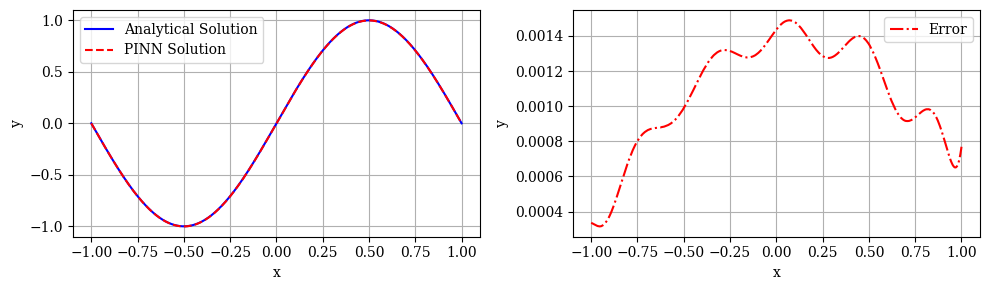

In [9]:
#----------------------------------------------------------------------#
# Evaluación del modelo y visualización de resultados
#----------------------------------------------------------------------#

# Se generan puntos de prueba, se calcula la solución predicha por la
# red neuronal y se compara con la solución exacta. Finalmente, se grafican
# ambas soluciones para visualizar la precisión del modelo entrenado.

# Predicción de la solución en puntos de prueba
x_test = np.linspace(xI, xF, 1000).reshape(-1, 1)             # 1000 puntos uniformemente distribuidos en el dominio
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)       # Conversión a tensor para evaluar con el modelo
y_pred = call_model(model, x_test).numpy()                    # Predicción del modelo convertida a arreglo de NumPy

# Solución analítica (exacta) para comparación
x_test_np = x_test.numpy()                                    # Conversión del tensor a NumPy para graficar
y_true    = u_exact(x_test_np)

abs_error = np.abs(y_true - y_pred)
error = np.mean(abs_error)
print(f"\n--> Error absoluto promedio: {error:.6f}\n")

# Configuración del estilo del gráfico
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

# Gráfica de resultados
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(x_test_np, y_true, 'b-', label='Analytical Solution')
ax[0].plot(x_test_np, y_pred, 'r--', label='PINN Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(x_test_np, abs_error, '-.r', label='Error')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend()
ax[1].grid(True)


plt.tight_layout()
plt.show()


--> Error absoluto promedio: 0.001073



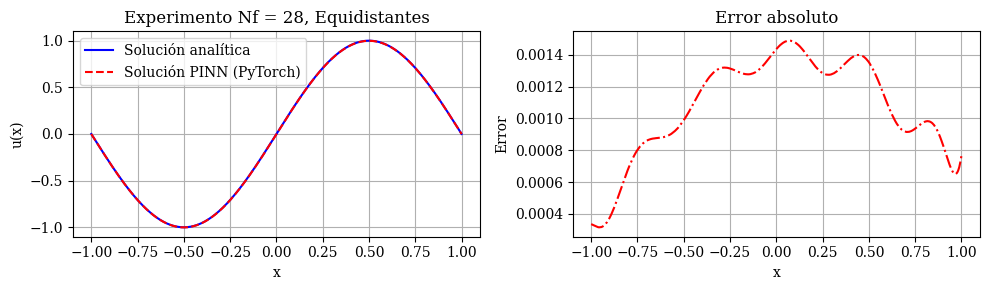

In [20]:
# Error absoluto promedio
abs_error = np.abs(y_true - y_pred)
error = np.mean(abs_error)
print(f"\n--> Error absoluto promedio: {error:.6f}\n")

# Configuración del estilo del gráfico
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100


fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Gráfica de resultados
# ax[0].figure(figsize=(5, 3))
ax[0].set_title(f'Experimento Nf = {Nf}, Equidistantes')
ax[0].plot(x_test, y_true, 'b-', label='Solución analítica')
ax[0].plot(x_test, y_pred, 'r--', label='Solución PINN (PyTorch)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('u(x)')
ax[0].grid(True)
ax[0].legend()

# Gráfica de errores
# ax[1].figure(figsize=(5, 3))
ax[1].plot(x_test, abs_error, '-.r', label='Error absoluto')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')

ax[1].set_title('Error absoluto')
ax[1].grid(True)

plt.tight_layout()
plt.savefig(f'Equi{Nf}_tf.png')
plt.show()